# Изработка на задача за пракса во Loka

### Изработува: Славе Темков

Најпрво, со помош на Selenium ги влечам податоците. Пробав колку што можам повеќе податоци да земам, но малку е тешко бидејќи немаат иста структура секој пат кога ги објавуваат.

In [59]:
from selenium import webdriver
import re
import pandas as pd
driver = webdriver.Chrome()
data = {}
data['datum'] = []
data['vkupno'] = []
data['novi'] = []
data['ozdraveni'] = []
data['pochinati'] = []
for i in range(14,0,-1):
    url = 'https://koronavirus.gov.mk/vesti/category/izvestuvanja/page/' + str(i) + '?et_blog'
    driver.get(url)
    links = driver.find_elements_by_css_selector('h2 > a')
    links = links[1:]
    links.reverse()
    dates = [el.text for el in driver.find_elements_by_css_selector('p > span.published')]
    dates = [d.split(' | ')[0] for d in dates]
    dates.reverse()
    for i in range(len(links)):
        text = links[i].text.lower()
        if 'дијагностициран' in text:
            datum = dates[i]
            novi = 0
            vkupno = 0
            ozdraveni = 0
            smrtni = 0
            parts1 = text.split('–')
            for t in parts1:
                parts2 = t.split(',')
                for p in parts2:
                    nums = re.findall(r'\d+',p)
                    if len(nums) > 0:
                        num = int(nums[0])
                        if 'дијагностициран' in p:
                            vkupno = num
                            continue
                        if 'нов' in p:
                            novi = num
                            continue
                        if 'оздравен' in p:
                            ozdraveni = num
                            continue
                        if 'почина' in p or 'смрт' in p:
                            smrtni = num
                            continue
            if vkupno!=0:
                data['datum'].append(datum)
                data['vkupno'].append(vkupno)
                data['novi'].append(novi)
                data['ozdraveni'].append(ozdraveni)
                data['pochinati'].append(smrtni)
df = pd.DataFrame.from_dict(data)
print(df.head)

<bound method NDFrame.head of          datum  vkupno  novi  ozdraveni  pochinati
0   08.04.2020     617    18          5          2
1   14.04.2020     908    54         42          6
2   15.04.2020     974    66         12          1
3   16.04.2020    1081   107         23          1
4   17.04.2020    1117    36         18          3
5   19.04.2020    1207    37         15          2
6   21.04.2020    1231     7         24          1
7   20.04.2020    1225    18         21          3
8   18.04.2020    1170    53         25          0
9   22.04.2020    1259    28          0          1
10  25.04.2020    1367    41         37          2
11  26.04.2020    1386    19        126          2
12  23.04.2020    1300    41         29          0
13  27.04.2020    1399    13         53          4
14  28.04.2020    1421    22         36          6
15  29.04.2020    1442    21         38          2
16  01.05.2020    1494    29         69          4
17  07.05.2020    1572    33          0          0
1

In [60]:
df = df.sort_values('vkupno')
print(df.head)

<bound method NDFrame.head of          datum  vkupno  novi  ozdraveni  pochinati
0   08.04.2020     617    18          5          2
1   14.04.2020     908    54         42          6
2   15.04.2020     974    66         12          1
3   16.04.2020    1081   107         23          1
4   17.04.2020    1117    36         18          3
8   18.04.2020    1170    53         25          0
5   19.04.2020    1207    37         15          2
7   20.04.2020    1225    18         21          3
6   21.04.2020    1231     7         24          1
9   22.04.2020    1259    28          0          1
12  23.04.2020    1300    41         29          0
10  25.04.2020    1367    41         37          2
11  26.04.2020    1386    19        126          2
13  27.04.2020    1399    13         53          4
14  28.04.2020    1421    22         36          6
15  29.04.2020    1442    21         38          2
16  01.05.2020    1494    29         69          4
18  02.05.2020    1506    15         45          1
1

Можеме да видиме дека понекогаш во подолг период ни фалат податоци, пример немаме за неколку дена по ред. Затоа, за да се конзистентни податоците во тој поглед, ќе направам интерполација на тие „дупки“ во податоците, на тој начин што ќе претпоставам дека во тој период бројот на заболени се зголемува со рамномерна распределба. Целта на ова е за да можеме да ги искористиме податоците во модел за предвидување на временски серии.

In [61]:
datumi = list(df['datum'])
vkupno = list(df['vkupno'])
novi = list(df['novi'])
print(datumi)
numbering = []
for datum in datumi:
    den = int(datum[:2])
    mesec = datum[3:5]
    if mesec == '04':
        numbering.append(den-8)
    else:
        numbering.append(den+22)
ind = -1
razlika = 0
br = 1
missing_num = 0
last = 0
for i in range(numbering[-1]):
    if i in numbering:
        ind+=1
        razlika = vkupno[ind+1] - novi[ind+1] - vkupno[ind]
        br = 1
        missing_num = numbering[ind+1] - numbering[ind] - 1
        last = vkupno[ind]
    else:
        if i <= 22:
            datum = '%02d' % (8+i)
            datum += '.04.2020'
        else:
            datum = '%02d' % (i - 22)
            datum += '.05.2020'
        brnovi = razlika // missing_num
        if br==1 and razlika%missing_num!=0:
            brnovi+=razlika%missing_num
        last = last + brnovi
        datumi.append(datum)
        vkupno.append(last)
        novi.append(brnovi)
        br+=1
r = {}
r['date'] = datumi
r['vkupno'] = vkupno
r['novi'] = novi
new_df = pd.DataFrame.from_dict(r)
new_df = new_df.sort_values('vkupno')
print(new_df.head)

['08.04.2020', '14.04.2020', '15.04.2020', '16.04.2020', '17.04.2020', '18.04.2020', '19.04.2020', '20.04.2020', '21.04.2020', '22.04.2020', '23.04.2020', '25.04.2020', '26.04.2020', '27.04.2020', '28.04.2020', '29.04.2020', '01.05.2020', '02.05.2020', '07.05.2020', '08.05.2020', '09.05.2020', '12.05.2020', '13.05.2020']
<bound method NDFrame.head of           date  vkupno  novi
0   08.04.2020     617    18
23  09.04.2020     666    49
24  10.04.2020     713    47
25  11.04.2020     760    47
26  12.04.2020     807    47
27  13.04.2020     854    47
1   14.04.2020     908    54
2   15.04.2020     974    66
3   16.04.2020    1081   107
4   17.04.2020    1117    36
5   18.04.2020    1170    53
6   19.04.2020    1207    37
7   20.04.2020    1225    18
8   21.04.2020    1231     7
9   22.04.2020    1259    28
10  23.04.2020    1300    41
28  24.04.2020    1326    26
11  25.04.2020    1367    41
12  26.04.2020    1386    19
13  27.04.2020    1399    13
14  28.04.2020    1421    22
15  29.04

Следно, ќе ги исцртаме податоците во график, во однос на времето. Временските точки ќе ги означиме од 0 (означувајќи го првиот ден за кој што имаме податоци), до вкупниот број на денови кој што го имаме (означувајќи го последниот ден за кој што имаме податоци). Не ги ставив датите за да биде попрегледно на x-оската.

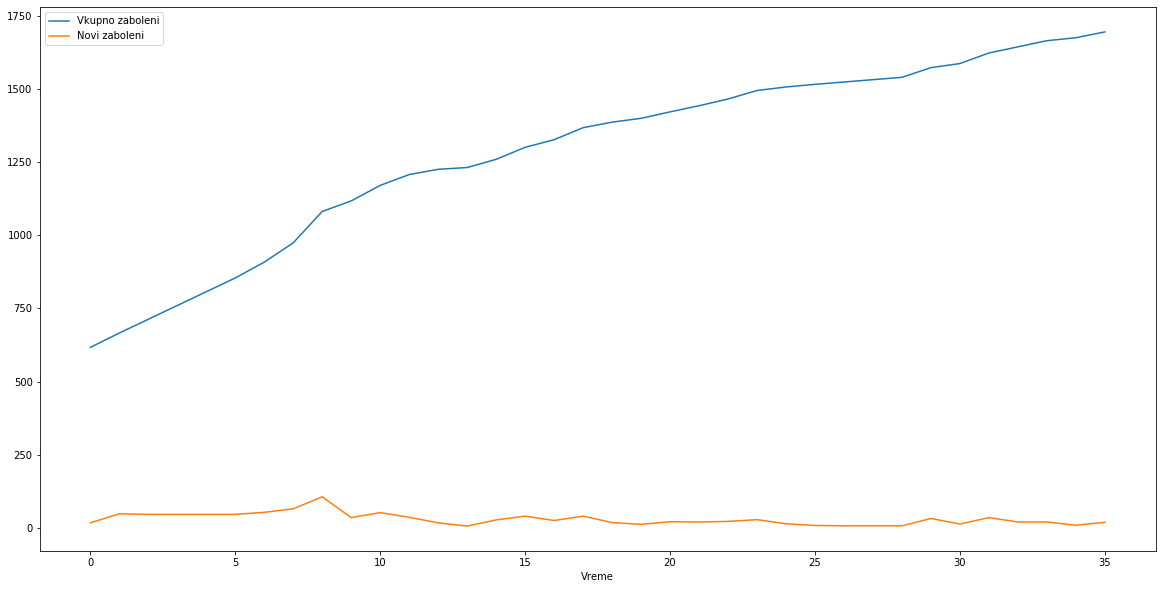

In [62]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
plt.xlabel('Vreme')
vreme = [i for i in range(numbering[-1]+1)]
plt.plot(vreme,list(new_df['vkupno']),label = 'Vkupno zaboleni')
plt.plot(vreme,list(new_df['novi']),label = 'Novi zaboleni')
plt.legend()

Како што спомнав погоре, би било најповолно да се користи модел за предвидување на временски серии. Во овој случај јас одлучив да истренирам два модели, едниот користејќи ги податоците за вкупно заболените до тој ден, а друг користејќи ги податоците за бројот на ново заболени за тој ден. Од првиот модел ќе можеме да го добиеме бројот на ново заболени ако од предвидениот број го одземиме бројот на вкупно заболени од последниот ден во податоците кои ги имаме. Потоа, предвидувањето можеме да го направиме на тој начин што ќе земеме некаков тежински збир на двете предвидувања. На почеток ќе поставам поголема тежина за првиот модел (тој што ги користи бројот на вкупно заболени до тој ден, бидејќи ни дава повеќе информации), но пример ова понатаму може да се модифицира доколку се користи моделот, со тоа што ќе гледаме кое од предвидувањата е поточно, и на тоа ќе му се зголемува тежината.

In [64]:
from statsmodels.tsa.arima_model import ARIMA
weight1 = 0.7
weight2 = 0.3
data1 = new_df['vkupno'].values
model1 = ARIMA(data1, order=(1, 1, 1))
model1_fit = model1.fit(disp=False)
pred1 = model1_fit.predict(len(data1), len(data1), typ='levels')[0] - data1[-1]
data2 = new_df['novi'].values
model2 = ARIMA(data2, order=(1, 1, 1))
model2_fit = model2.fit(disp=False)
pred2 = model2_fit.predict(len(data2), len(data2), typ='levels')[0]
print(pred1)
print(pred2)
pred = int(round(weight1*pred1 + weight2*pred2))
print(pred)
print(data1[-1] + pred)

21.678660802121385
13.582327256823461
19
1713


Според ваквите резултати, добиваме дека за следниот ден ќе имаме 19 нови заболени, односно вкупно 1713 заболени.